<a href="https://colab.research.google.com/github/alejandro-robles7/fbai-mlops-assignments/blob/main/week_2/Assignment_Data_Pipeline_for_Diabetic_Patients.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


## This assignment is based on the "Roche" Machine Learning Exercise given in 
https://colab.research.google.com/drive/1-P712Hw8KeVA1bV2AdnyHcT3WzNPMc2N



## Today you are a Data Engineer at Roche medical research team and your team has been working on developing predictive markers for Diabetes. 
* ## Your team will be receiving small batches of data, based on which you will then be able to build and deploy machine learning models to predict "Which patients are at risk for Diabetes" vs. normal patients. 
* ## You will make your predictions based on predicted Blood Glucose Levels.

## Details of your dataset are as follows:
Dataset source: https://www4.stat.ncsu.edu/~boos/var.select/diabetes.html
* Samples batch size: 100
* Dimensionality: 10
* Features: real, -.2 < x < .2
* Blood Glucose Level: (25 - 350)

# **Your task is to create a Data Pipeline to receive data batches and perform the following checks**:
* ## **Pre-process the dataset to eliminate outliers or erroneous samples.**
* ## **Detect samples that are "easy" vs "difficult" to classify based on their clustering patterns.** This will help build better ML models for future data sets.


## **Learning Objectives:**
  * Create a Data Pipeline to receive data until a critical mass of data is received to build models thereafter.
  * Identify features about the data to aid storage and retrieval.
  * Build ML models using a subset of the curated data.

## As a first step, we install the libraries we will need later on.

In [1]:
!pip install --upgrade plotly

In [2]:
!pip install jupyter-dash

# **Task 1: Pre-processing data batches. Elimininate erroneous/incomplete samples.**

Use prior knowledge in this case regarding the maximum and minimum values each feature/sample labels can take

In [3]:
# As a first step we import all required libraries.
import matplotlib.pyplot as plt

from sklearn.datasets import load_diabetes
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
import seaborn as sns
import numpy as np
import pandas as pd

# Now, we read the data and receive batches of data in increments of 100. 

In [4]:
#First we look into the first 100 samples
X, y = load_diabetes(return_X_y=True)

In [5]:
X.shape

(442, 10)

## Write a function 'return_dataframe' that takes in batches of data (in increments of 100) as input and returns a dataframe with the 'labels' y appended as the last column.

In [6]:
def return_dataframe(X_batch, y_batch, y_label='labels', batch_size=100) -> pd.DataFrame:
  #####Enter Code Here
  #######################
  df = pd.DataFrame(X_batch)
  df[y_label] = y_batch
  if X_batch.shape[0] != batch_size:
    print('Not the right batch size')
  return df


In [7]:
df=return_dataframe(X[:100,:],y[:100])  
df.head()

,0,1,2,3,4,5,6,7,8,9,labels
0,0.038076,0.050680,0.061696,0.021872,-0.044223,-0.034821,-0.043401,-0.002592,0.019908,-0.017646,151.0
1,-0.001882,-0.044642,-0.051474,-0.026328,-0.008449,-0.019163,0.074412,-0.039493,-0.068330,-0.092204,75.0
2,0.085299,0.050680,0.044451,-0.005671,-0.045599,-0.034194,-0.032356,-0.002592,0.002864,-0.025930,141.0
3,-0.089063,-0.044642,-0.011595,-0.036656,0.012191,0.024991,-0.036038,0.034309,0.022692,-0.009362,206.0
4,0.005383,-0.044642,-0.036385,0.021872,0.003935,0.015596,0.008142,-0.002592,-0.031991,-0.046641,135.0


# Now, you need to create a function ('return_viable_samples') to check if any sample features are in error (NaN, or out of the range). 
## The function takes the batch dataframe as input, eliminates samples that are out of range or NaN valued, and converts the labels to binarized form such that df['labels']=1 for Glucose>=140 and df['labels']=0 for Glucose<140.

In [8]:
def subset_by_column(dataframe: pd.DataFrame, column_name: str, exclude=True):
    if exclude:
        return dataframe.loc[:, dataframe.columns != column_name]
    else:
        return dataframe.loc[:, dataframe.columns == column_name]


def f(row, threshold=2, leq=True):
    if leq:
        return row.max() <= threshold
    else:
        return row.min() >= threshold


def get_filter(dataframe: pd.DataFrame, column_name:str, range_filter: list, exclude=True):
    subset_df = subset_by_column(dataframe=dataframe, column_name=column_name, exclude=exclude)
    leq_filter = subset_df.apply(lambda x: f(row=x, threshold=range_filter[0], leq=False), axis=1)
    geq_filter = subset_df.apply(lambda x: f(row=x, threshold=range_filter[1], leq=True), axis=1)
    row_feature_filter = leq_filter & geq_filter
    return row_feature_filter


def return_viable_samples(df, y_label='labels', binary_threshold=140) -> pd.DataFrame:
    # for each feature verify if they lie in the range [-0.2,0.2]
    # for each y value, verify if they lie in range [25-350]
    # if not then eliminate the sample
    ############Enter your code here####################

    feature_range = [-0.2, 0.2]
    label_range = [25, 350]

    feature_filter = get_filter(dataframe=df, column_name=y_label, range_filter=feature_range, exclude=True)
    label_filter = get_filter(dataframe=df, column_name=y_label, range_filter=label_range, exclude=False)

    final_filter = feature_filter & label_filter

    df = df[final_filter].copy()
    df[y_label] = (df[y_label] >= binary_threshold).astype(int)
    return df

In [9]:
df_viable=return_viable_samples(df)
df_viable.head()

,0,1,2,3,4,5,6,7,8,9,labels
0,0.038076,0.050680,0.061696,0.021872,-0.044223,-0.034821,-0.043401,-0.002592,0.019908,-0.017646,1
1,-0.001882,-0.044642,-0.051474,-0.026328,-0.008449,-0.019163,0.074412,-0.039493,-0.068330,-0.092204,0
2,0.085299,0.050680,0.044451,-0.005671,-0.045599,-0.034194,-0.032356,-0.002592,0.002864,-0.025930,1
3,-0.089063,-0.044642,-0.011595,-0.036656,0.012191,0.024991,-0.036038,0.034309,0.022692,-0.009362,1
4,0.005383,-0.044642,-0.036385,0.021872,0.003935,0.015596,0.008142,-0.002592,-0.031991,-0.046641,0


In [10]:
df.describe().loc[['min', 'max']] 

,0,1,2,3,4,5,6,7,8,9,labels
min,-0.107226,-0.044642,-0.083808,-0.108957,-0.126781,-0.106845,-0.102307,-0.076395,-0.096433,-0.129483,37.0
max,0.085299,0.050680,0.125287,0.125158,0.103003,0.108914,0.181179,0.108111,0.133599,0.135612,341.0


# **Task 2: Metadata Generation for Faster Storage and Retrieval.**
Our goal is to identify samples that are "Easy" vs "Difficult" to classify, based on the spatial clustering patterns.

## Goal (Unsupervised Learning): Perform clustering on the "viable" samples per batch to identify the following:
* The "Easy" samples as ones that are closer to the cluster center and away from cluster boundary.
* The "Difficult samples as ones that are far away from the cluster center and along the decision boundary.

### Step 1: Perform PCA (dimensionality reduction) on the viable samples per batch and visualize the samples. Instead of PCA, you can also perform feature ranking and select the top 3 ranked features for this task. This is for visualization ONLY!

In [11]:
# reduce the data to 3 dimensional. 
from sklearn.decomposition import PCA
X_b=df_viable.iloc[:,:9].values
y_b=df_viable.iloc[:,10].values
pca=PCA(n_components=3)
X_red=pca.fit_transform(X_b)

In [12]:
data=pd.DataFrame(X_red,columns = ['PC1','PC2','PC3'])
data['labels']=y_b
data.head()

,PC1,PC2,PC3,labels
0,0.079283,-0.047286,0.084290,1
1,-0.080987,0.056956,-0.013405,0
2,0.070035,-0.028062,0.101429,1
3,0.021351,-0.049986,-0.099122,1
4,0.005135,0.029675,-0.026076,0


In [13]:
# Now, we plot the samples from the first 100 samples to see if the samples from Diabetic/vs not Diabetic clusters overlap or not.
import plotly.express as px

fig = px.scatter_3d(data, x='PC1', y='PC2', z='PC3',color='labels')
fig.show()

## **So we notice that all the samples ar not eaqually easy to classify.**
Some are away from the decision boundary (easy to classify) while several samples lie along the decision boundary (difficult to classify). We will now tag the samples as Easy/Diiffult to classify!

## Step 2: Identify "Easy" and "Difficult" to classify samples using the some "Clustering Performance Evaluation Metrics" at https://scikit-learn.org/stable/modules/clustering.html#clustering-performance-evaluation

### One way of identifying "Difficult" samples is to perform k-means clustering on all the data and identify the samples that get misclassified. You can come up with your own function to identify "Easy" and "Difficult" samples.

# **Create a function that accepts a batch of viable samples and appends a column at the end that indicates if the sample is "Easy or Not".**

### One well known metric is the **Sihouette score** per sample that identifies if the sample is at cluster boundary or not. +1= "Easy" sample, close to 0 value implies overlapping clusters or "Difficult" sample. Use the command in the [sklearn documentation page](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_samples.html#:~:text=The%20Silhouette%20Coefficient%20is%20calculated,n_labels%20%3C%3D%20n_samples%20%2D%201%20.)

(array([ 6.,  6.,  7.,  5.,  5., 10., 18., 20., 14.,  9.]),
 array([-0.03036938,  0.02774819,  0.08586577,  0.14398334,  0.20210092,
         0.26021849,  0.31833607,  0.37645364,  0.43457122,  0.49268879,
         0.55080637]),
 <a list of 10 Patch objects>)

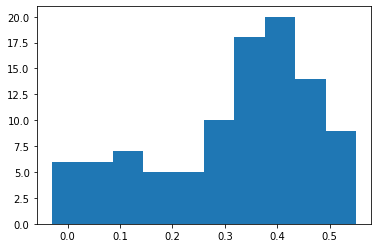

In [14]:
import numpy as np
from sklearn import metrics
from sklearn.cluster import KMeans
kmeans_model = KMeans(n_clusters=2, random_state=1).fit(X_red)
labels = kmeans_model.labels_
vals=metrics.silhouette_samples(X_red, labels)
plt.hist(vals)

## In this case, we can **empirically use a threshold of 0.2** for silhouette scores per sample. So, all samples with silhouette scores>=0.2 are "easy" and all remaining samples are "difficult". Add a column to dataframe "data" as the (Easy/or not) label.

# **Note that the threshold for Silhouette scores of 0.2 can be experimentally determined through quartile estimations as well. In this case we look at the histogram above and see that most samples have high scores between [0.3-0.55]. So we arbitrarily set up the threshold of 0.2 here.**

In [15]:
easy=(vals>=0.2).astype(int)
df_viable['Easy']=easy
df_viable.head()

,0,1,2,3,4,5,6,7,8,9,labels,Easy
0,0.038076,0.050680,0.061696,0.021872,-0.044223,-0.034821,-0.043401,-0.002592,0.019908,-0.017646,1,1
1,-0.001882,-0.044642,-0.051474,-0.026328,-0.008449,-0.019163,0.074412,-0.039493,-0.068330,-0.092204,0,1
2,0.085299,0.050680,0.044451,-0.005671,-0.045599,-0.034194,-0.032356,-0.002592,0.002864,-0.025930,1,1
3,-0.089063,-0.044642,-0.011595,-0.036656,0.012191,0.024991,-0.036038,0.034309,0.022692,-0.009362,1,0
4,0.005383,-0.044642,-0.036385,0.021872,0.003935,0.015596,0.008142,-0.002592,-0.031991,-0.046641,0,0


## **Now write a function that combines the learnings so far.** 
So this function 'return_tagged_data' takes as input a dataframe containing the viable samples and performs k-means clustering, and using the labels computes silhouette scores (SS) per sample and tags the samples with SS>=0.2 as df['Easy']=1 and all other samples as df['Easy']=0.

In [16]:
def return_tagged_data(df: pd.DataFrame, threshold=0.2, n_clusters=2, random_state=0):
  #Enter code here###
  X_red = subset_by_column(dataframe=df, column_name='labels', exclude=True).to_numpy()
  kmeans_model = KMeans(n_clusters=n_clusters, random_state=random_state).fit(X_red)
  labels = kmeans_model.labels_
  vals = metrics.silhouette_samples(X_red, labels)
  easy = (vals>=threshold).astype(int)
  df['Easy'] = easy
  return df
  

In [17]:
df_viable_1=return_tagged_data(df_viable)
df_viable_1.head()

,0,1,2,3,4,5,6,7,8,9,labels,Easy
0,0.038076,0.050680,0.061696,0.021872,-0.044223,-0.034821,-0.043401,-0.002592,0.019908,-0.017646,1,1
1,-0.001882,-0.044642,-0.051474,-0.026328,-0.008449,-0.019163,0.074412,-0.039493,-0.068330,-0.092204,0,1
2,0.085299,0.050680,0.044451,-0.005671,-0.045599,-0.034194,-0.032356,-0.002592,0.002864,-0.025930,1,1
3,-0.089063,-0.044642,-0.011595,-0.036656,0.012191,0.024991,-0.036038,0.034309,0.022692,-0.009362,1,1
4,0.005383,-0.044642,-0.036385,0.021872,0.003935,0.015596,0.008142,-0.002592,-0.031991,-0.046641,0,1


# By now you have pre-processed the data as much as possible. The next task will be to build an ML model for classification of patients with and without Diabetes.

# **Task 3: Setting up Classification**
* Step 1: We will collect data from 2 batches of 100 samples each and build an ML model (linear or non-linear), then test the model for classification on the next betches of data.
* Step 2: We will collect only "Easy samples" from first 2 batches of 100 samples, build an ML model and test on only easy samples of the remaining data batches.
* Step 3: We will collect only "Difficult samples" from first 2 batches of 100 samples, build an ML model and test on only easy samples of the remaining data batches.

# **We will report the variation in ML model performance based on the tagged samples.**

Reuse as much code as needed from the Colab: https://colab.research.google.com/drive/1-P712Hw8KeVA1bV2AdnyHcT3WzNPMc2N

In [18]:
train_data=return_dataframe(X[:100,:],y[:100])


In [19]:
train_data=train_data.append(return_dataframe(X[101:200,:],y[101:200]))
train_data.shape

Not the right batch size


(199, 11)

In [20]:
train_data.head()

,0,1,2,3,4,5,6,7,8,9,labels
0,0.038076,0.050680,0.061696,0.021872,-0.044223,-0.034821,-0.043401,-0.002592,0.019908,-0.017646,151.0
1,-0.001882,-0.044642,-0.051474,-0.026328,-0.008449,-0.019163,0.074412,-0.039493,-0.068330,-0.092204,75.0
2,0.085299,0.050680,0.044451,-0.005671,-0.045599,-0.034194,-0.032356,-0.002592,0.002864,-0.025930,141.0
3,-0.089063,-0.044642,-0.011595,-0.036656,0.012191,0.024991,-0.036038,0.034309,0.022692,-0.009362,206.0
4,0.005383,-0.044642,-0.036385,0.021872,0.003935,0.015596,0.008142,-0.002592,-0.031991,-0.046641,135.0


In [21]:
train_data=return_viable_samples(train_data)

In [22]:
train_data.head()

,0,1,2,3,4,5,6,7,8,9,labels
0,0.038076,0.050680,0.061696,0.021872,-0.044223,-0.034821,-0.043401,-0.002592,0.019908,-0.017646,1
1,-0.001882,-0.044642,-0.051474,-0.026328,-0.008449,-0.019163,0.074412,-0.039493,-0.068330,-0.092204,0
2,0.085299,0.050680,0.044451,-0.005671,-0.045599,-0.034194,-0.032356,-0.002592,0.002864,-0.025930,1
3,-0.089063,-0.044642,-0.011595,-0.036656,0.012191,0.024991,-0.036038,0.034309,0.022692,-0.009362,1
4,0.005383,-0.044642,-0.036385,0.021872,0.003935,0.015596,0.008142,-0.002592,-0.031991,-0.046641,0


In [23]:
train_data.describe().loc[['min', 'max']] 

,0,1,2,3,4,5,6,7,8,9,labels
min,-0.107226,-0.044642,-0.083808,-0.108957,-0.126781,-0.106845,-0.102307,-0.076395,-0.126097,-0.129483,0.0
max,0.085299,0.050680,0.128521,0.125158,0.152538,0.198788,0.181179,0.185234,0.133599,0.135612,1.0


In [24]:
test_data=return_dataframe(X[201:,:],y[201:])
test_data=return_viable_samples(test_data)
print(test_data.shape)
test_data.head()

Not the right batch size
(241, 11)


,0,1,2,3,4,5,6,7,8,9,labels
0,-0.034575,0.050680,-0.055785,-0.015999,-0.009825,-0.007890,0.037595,-0.039493,-0.052959,0.027917,0
1,0.081666,0.050680,0.001339,0.035644,0.126395,0.091065,0.019187,0.034309,0.084495,-0.030072,1
2,-0.001882,0.050680,0.030440,0.052858,0.039710,0.056619,-0.039719,0.071210,0.025393,0.027917,1
3,0.110727,0.050680,0.006728,0.028758,-0.027712,-0.007264,-0.047082,0.034309,0.002008,0.077622,1
4,-0.030942,-0.044642,0.046607,0.014987,-0.016704,-0.047034,0.000779,-0.002592,0.063456,-0.025930,0


In [25]:
return_dataframe(X[201:,:],y[201:]).describe()

Not the right batch size


,0,1,2,3,4,5,6,7,8,9,labels
count,241.000000,241.000000,241.000000,241.000000,241.000000,241.000000,241.000000,241.000000,241.000000,241.000000,241.000000
mean,0.005473,0.001635,0.002318,0.003344,0.003695,0.002746,-0.000665,0.003073,0.003447,0.002978,156.460581
std,0.047105,0.047740,0.049251,0.049207,0.049599,0.048600,0.047707,0.047563,0.048860,0.046248,79.111100
min,-0.107226,-0.044642,-0.090275,-0.112400,-0.108893,-0.115613,-0.098625,-0.076395,-0.104365,-0.137767,31.000000
25%,-0.027310,-0.044642,-0.033151,-0.033214,-0.031840,-0.028871,-0.032356,-0.039493,-0.033249,-0.030072,85.000000
50%,0.009016,-0.044642,-0.007284,-0.004523,-0.002945,-0.002566,-0.006584,-0.002592,0.001144,0.003064,147.000000
75%,0.038076,0.050680,0.034751,0.042530,0.035582,0.034698,0.022869,0.034309,0.034864,0.032059,220.000000
max,0.110727,0.050680,0.170555,0.132044,0.153914,0.155887,0.177497,0.155345,0.133396,0.135612,346.000000


In [26]:
test_data.describe().loc[['min', 'max']] 

,0,1,2,3,4,5,6,7,8,9,labels
min,-0.107226,-0.044642,-0.090275,-0.112400,-0.108893,-0.115613,-0.098625,-0.076395,-0.104365,-0.137767,0.0
max,0.110727,0.050680,0.170555,0.132044,0.153914,0.155887,0.177497,0.155345,0.133396,0.135612,1.0


In [27]:
X_train=train_data.iloc[:,0:9].values
y_train=train_data['labels']
X_test=test_data.iloc[:,0:9].values
y_test=test_data['labels']

In [28]:
X_train.shape

(199, 9)

#  Your Training and test data are now ready! Now, select your favourite classifier and beginning fitting models. 

In [29]:
# Write code here to fit an ML model using (X_train,y_train) and evaluate on X_test
from sklearn.linear_model import LogisticRegression
pred = LogisticRegression().fit(X_train, y_train).predict(X_test)

In [30]:
# This function generates eclassifier evaluations
def evaluate_classifier(z_test,reg_pred):
  cm_1 = metrics.confusion_matrix(z_test, reg_pred)
  acc_1   = metrics.accuracy_score(z_test, reg_pred)
  rec_1   = metrics.recall_score(z_test, reg_pred)
  prec_1  = metrics.precision_score(z_test, reg_pred) 
  print(f'Accuracy = {acc_1}, Precision = {prec_1}, Recall = {rec_1}')
  print('Confusion Matrix is:')
  print(cm_1)

In [31]:
evaluate_classifier(y_test,pred)

Accuracy = 0.7468879668049793, Precision = 0.7946428571428571, Recall = 0.7007874015748031
Confusion Matrix is:
[[91 23]
 [38 89]]


### Step 2: Now build model for "Easy" samples only and test on easy samples only

In [32]:
train_data_tagged=return_tagged_data(train_data)
test_data_tagged=return_tagged_data(test_data)
train_data_tagged.head()

,0,1,2,3,4,5,6,7,8,9,labels,Easy
0,0.038076,0.050680,0.061696,0.021872,-0.044223,-0.034821,-0.043401,-0.002592,0.019908,-0.017646,1,0
1,-0.001882,-0.044642,-0.051474,-0.026328,-0.008449,-0.019163,0.074412,-0.039493,-0.068330,-0.092204,0,1
2,0.085299,0.050680,0.044451,-0.005671,-0.045599,-0.034194,-0.032356,-0.002592,0.002864,-0.025930,1,0
3,-0.089063,-0.044642,-0.011595,-0.036656,0.012191,0.024991,-0.036038,0.034309,0.022692,-0.009362,1,0
4,0.005383,-0.044642,-0.036385,0.021872,0.003935,0.015596,0.008142,-0.002592,-0.031991,-0.046641,0,0


# Extract the 'Easy' samples only and create [X_train_e, y_train_e, X_test_e, y_yest_e].

In [33]:
# Enter code here to create [X_train_e, y_train_e, X_test_e, y_yest_e]
def get_splits(train_df: pd.DataFrame, test_df: pd.DataFrame, column_label='labels'):
  X_train=train_df.iloc[:,0:9].values
  y_train=train_df[column_label]
  X_test=test_df.iloc[:,0:9].values
  y_test=test_df[column_label]
  return X_train, y_train, X_test, y_test

def get_samples(dataframe: pd.DataFrame, easy=True, column_name='Easy'):
  if easy:
     return dataframe[dataframe[column_name] == 1]
  else:
    return dataframe[dataframe[column_name] == 0]


X_train_e, y_train_e, X_test_e, y_test_e = get_splits(
    train_df=get_samples(train_data_tagged),
    test_df=get_samples(test_data_tagged)
)

In [34]:
pred_e = LogisticRegression().fit(X_train_e, y_train_e).predict(X_test_e)

In [35]:
evaluate_classifier(y_test_e,pred_e)

Accuracy = 0.803921568627451, Precision = 0.8533333333333334, Recall = 0.7710843373493976
Confusion Matrix is:
[[59 11]
 [19 64]]


# Step 3: Build the classifier for "Not easy samples now"

In [36]:
# Enter code here to create [X_train_d, y_train_d, X_test_d, y_yest_d]
X_train_d, y_train_d, X_test_d, y_test_d = get_splits(
    train_df=get_samples(train_data_tagged, False),
    test_df=get_samples(test_data_tagged, False)
)

In [37]:
pred_d = LogisticRegression().fit(X_train_d, y_train_d).predict(X_test_d)

In [38]:
evaluate_classifier(y_test_d,pred_d)

Accuracy = 0.6477272727272727, Precision = 0.6511627906976745, Recall = 0.6363636363636364
Confusion Matrix is:
[[29 15]
 [16 28]]


## Notice that the same classifier performs poorly on Not Easy samples than on the Easy samples. Thus, it is best practize to fine tune for the "Difficult" samples while fitting the "Best ML Model". Report the following below:
* Accuracy/Precision/Recall for all samples (train on first 200 samples test on the rest)
* Accuracy/Precision/Recall for Easy samples (train on first 200 samples test on the rest)
* Accuracy/Precision/Recall for Not Easy samples (train on first 200 samples test on the rest)

# **Now we see the importance of Data Pipeline and metadata tagging to improve ML model tuning process. Samples on decision boundary are more important that samples that lie close to cluster centers!**

# Food for thought: How would you script the entire ML Data pipline that will receive data in continuous batches and store viable samples with tagged metadata that will trigger ML model tuning as soon as a critical mass of data is acquired!

We might be able to encode that logic using kubeflow or TFX. A lambda function can be used as well that is triggered by s3 event.